>
> # MaaS Sim tutorial
>
> ## Reinforced learning
>
-----
test how vehicle and driver rejects requests and how to control it via extrnal functions passed to simulator

import simulator

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import random
import logging
import pandas as pd
import seaborn as sns

In [3]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand  # simulator
from MaaSSim.traveller import travellerEvent
from MaaSSim.driver import driverEvent
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.decisions import f_stop_crit

In [4]:
params = get_config('../../data/config/default.json')  # load configuration

In [5]:
params.times.patience = 120 # 1 hour of simulation
params.simTime = 4 # 1 hour of simulation
params.nP = 100 # reuqests (and passengers)
params.nV = 100 # vehicles
params.nD = 30

user defined function to decide whether driver is active on a given day, based on previous experience

In [6]:
def f_my_driver_out(*args, **kwargs):
    # returns boolean True if vehicle decides to opt out
    leave_threshold = 0.25
    back_threshold = 0.5
    unserved_threshold = 0.005
    anneal = 0.2

    veh = kwargs.get('veh', None)  # input
    sim = veh.sim  # input
    flag = False  # output 
    if len(sim.runs) == 0: # first day
        msg = 'veh {} stays on'.format(veh.id) 
    else: 
        last_run = sim.run_ids[-1]
        avg_yesterday = sim.res[last_run].veh_exp.nRIDES.quantile(
            back_threshold)  # how many rides was there on average
        quant_yesterday = sim.res[last_run].veh_exp.nRIDES.quantile(
            leave_threshold)  # what was the lower quantile of rides

        prev_rides = pd.Series([sim.res[_].veh_exp.loc[veh.id].nRIDES for _ in
                                sim.run_ids]).mean()  # how many rides did I have on average before

        rides_yesterday = sim.res[last_run].veh_exp.loc[veh.id].nRIDES # how many rides did I have yesterday

        unserved_demand_yesterday = sim.res[last_run].pax_exp[sim.res[last_run].pax_exp.LOSES_PATIENCE > 0].shape[0] / \
                                    sim.res[last_run].pax_exp.shape[0]  # what is the share of unserved demand
        did_i_work_yesterday = sim.res[last_run].veh_exp.loc[veh.id].ENDS_SHIFT > 0 

        if not did_i_work_yesterday:
            if avg_yesterday < prev_rides:
                msg = 'veh {} stays out'.format(veh.id)
                flag = True
            elif unserved_demand_yesterday > unserved_threshold:
                if random.random() < anneal:
                    msg = 'veh {} comes to serve unserved'.format(veh.id)
                    flag = False
                else:
                    msg = 'veh {} someone else come to serve unserved'.format(veh.id)
                    flag = False
            else:
                msg = 'veh {} comes back'.format(veh.id)
                flag = False

            pass
        else:
            if rides_yesterday > quant_yesterday:
                msg = 'veh {} stays in'.format(veh.id)
                flag = False
            else:
                msg = 'veh {} leaves'.format(veh.id)
                flag = True

    sim.logger.info('DRIVER OUT: ' + msg)
    return flag

In [7]:
ret = list()
for i in range(10):
    print('repl',i)
    sim = simulate(params = params, f_driver_out = f_my_driver_out, f_stop_crit = f_stop_crit, logger_level = logging.CRITICAL)
    ret.append([sim.res[_].veh_exp[sim.res[_].veh_exp.ENDS_SHIFT>0].shape[0] for _ in sim.run_ids])

repl 0
repl 1
repl 2
repl 3
repl 4
repl 5
repl 6
repl 7
repl 8
repl 9


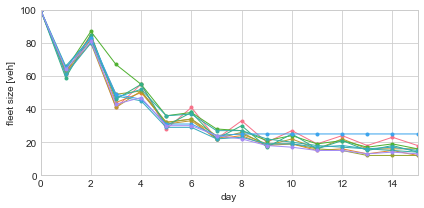

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,3))
plt.rcParams["font.family"] = "Times"
plt.style.use('seaborn-whitegrid')
df = pd.DataFrame(ret)
df = df.T.fillna(method = 'ffill')
i=0
for col in df.columns:    
    df[col].plot(lw = 1, alpha = 1,style='.-', ax = ax, color = sns.color_palette('husl',12)[i])
    i+=1
#df.T.mean().plot(lw = 1, color = 'black', ax = ax)
ax.set_ylim(0,100)
ax.set_xlim(0,15)
ax.set_ylabel('fleet size [veh]')
ax.set_xlabel('day')
fig.tight_layout()
plt.savefig('fig7.tif', dpi = 300)

-------------
Rafal Kucharski, 2020, Delft, r.m.kucharski@tudelft.nl